# Set up

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla

In [2]:
# 设置全局的字体大小和加粗 ### plt.rcParams
plt.rc('figure', figsize = [7,7])
plt.rc('font', size=20, weight='bold', family = 'Arial')  # 全局字体大小和加粗
plt.rc('axes', titlesize=20, titleweight='bold', titlepad = 15,
        labelpad=10, labelsize=18, labelweight='bold', linewidth = 1.2)  # 坐标轴标题和标签的字体
plt.rc('lines', linewidth = 2.2)
plt.rc('legend', framealpha = 0, loc = 'best')

plt.rc('xtick', labelsize=18, direction = 'in', top = True)  # x轴刻度标签字体大小
plt.rc('ytick', labelsize=18, direction = 'in', right = True)  # y轴刻度标签字体大小
plt.rc('xtick.major', size = 4, width = 2, pad = 4)  # x轴刻度线宽度
plt.rc('ytick.major', size = 4, width = 2, pad = 4)  # y轴刻度线宽度
plt.rc('xtick.minor', size = 2, width = 0.8, pad = 4)  # x轴刻度线宽度
plt.rc('ytick.minor', size = 2, width = 0.8, pad = 4)  # y轴刻度线宽度

# MOSCAP Solver

## Define a device Structure

In [3]:
class MOSCAP_Device:

    def __init__(
            self, 
            material_params = None, device_params = None, 
            electrical_params=None, physics_params=None, 
            math_params = None
    ):
        
        ### Define default parameters
        self.default_material_params = {

            'epsilon_IL': 3.9,  # Interfacial Layer Dielectric permittivity 
            'epsilon_Si': 11.7,  # Silicon permittivity

            'N_acceptor': 1e15 *1e6,  # Channel Acceptor Doping concentration in m^-3

            'N_c': 2.80e19 * 1e6,  # effective conduction band concentration in 1/m^3
            'N_v': 1.04e19 * 1e6,  # effective valance band concentration in 1/m^3
            'n_i': 6.80569e9 * 1e6,

            'E_g': 1.12,  # silicon bandgap in eV
        }

        self.default_device_params = {

            'dz': 0.2e-9,  # Grid spacing in z-direction in m
            'dx': 1e-9, # Grid spacing in x-direction in m

            'DE_thickness': 3e-9,  # DE thickness in m
            'Si_thickness': 10e-9,  # Silicon channel thickness in m
            'Si_length': 30e-9, # Silicon length in m

        }

        self.default_electrical_params = {

            'V_Gate': 1.0,  # Gate Voltage

        }

        self.default_physics_params = {

            'epsilon_0': 8.854e-12,
            'k_B': 1.38e-23, 
            'T_0': 300, 
            'e_charge': 1.6e-19,
            'Use_Boltzmann_distribution': True, 

        }

        self.default_math_params = {
            'Gummel_Max_iter': 10, # Gummel Map maximum number of iterations
            'Gummel_tolerance': 1e-6, # Gummel Map tollerance: V
            'Poisson_Solver': 'Sparse_Matrix', 

            'Poisson_Sparse_Matrix_max_update': 0.1, 

        }

        ### Update default parameters with any user-provided values
        if material_params:
            self.default_material_params.update(material_params)
        if device_params:
            self.default_device_params.update(device_params)
        if electrical_params:
            self.default_electrical_params.update(electrical_params)
        if physics_params:
            self.default_physics_params.update(physics_params)
        if math_params:
            self.default_math_params.update(math_params)
        
        ### initialize the device params and device physics variables and physics functions
        self.initialize_device_params()
        self.initialize_device_states()
        self.initialize_device_functions()

    def initialize_device_params(self):
        ###### Physics constant Parameters
        self.epsilon_0 = self.default_physics_params['epsilon_0']
        self.k_B = self.default_physics_params['k_B']
        self.T_0 = self.default_physics_params['T_0']
        self.e_charge = self.default_physics_params['e_charge']
        self.V_thermal = self.k_B * self.T_0 / self.e_charge # thermal voltage  = k_B * T_0 / q
        self.Use_Boltzmann_distribution = self.default_physics_params['Use_Boltzmann_distribution']

        ###### Device Material Parameters
        self.epsilon_IL = self.default_material_params['epsilon_IL']  # Interfacial Layer Dielectric permittivity 
        self.epsilon_Si = self.default_material_params['epsilon_Si']  # Silicon permittivity 
        
        self.N_acceptor = self.default_material_params['N_acceptor']  # Channel Acceptor Doping concentration in m^-3

        self.N_c = self.default_material_params['N_c']
        self.N_v = self.default_material_params['N_v']
        self.n_i = self.default_material_params['n_i']
        self.E_g = self.default_material_params['E_g']

        self.delta_E_0 = 0.5 * self.k_B * self.T_0 / self.e_charge * np.log(self.N_c/ self.N_v) # Energy reference point
        self.E_c = self.E_g/2 + self.delta_E_0
        self.E_v = -self.E_g/2 + self.delta_E_0


        ###### Device Structure Parameters
        self.dz = self.default_device_params['dz']  # Grid spacing in z-direction in m
        self.dx = self.default_device_params['dx']  # Grid spacing in x-direction in m

        self.DE_thickness_meter = self.default_device_params['DE_thickness']  # DE thickness in m
        self.Si_thickness_meter = self.default_device_params['Si_thickness']  # Silicon channel thickness in m
        self.Si_length = self.default_device_params['Si_length'] # Silicon length in m

        self.DE_thickness_grid = int(self.DE_thickness_meter/self.dz)
        self.Si_thickness_grid = int(self.Si_thickness_meter/self.dz)
        self.Si_length_grid = int(self.Si_length/self.dx) 

        ###### Device Electrical Parameters
        self.V_G = self.default_electrical_params['V_Gate']  # Gate Voltage

        ###### Simulation Math Parameters   
        self.Gummel_Max_iter = self.default_math_params['Gummel_Max_iter']
        self.Gummel_tolerance = self.default_math_params['Gummel_tolerance']
        self.Poisson_Solver = self.default_math_params['Poisson_Solver']

        self.Poisson_Sparse_Matrix_max_update = self.default_math_params['Poisson_Sparse_Matrix_max_update'] 

    def initialize_device_states(self):
        
        ### Silicon doping profile
        self.acceptor_profile = np.zeros(
            (self.Si_length_grid + 1, self.Si_thickness_grid + 1)
        )

        self.acceptor_profile[:] = self.N_acceptor


        ### physics variable arrays initialization
        self.V_grid = np.zeros(
            (self.Si_length_grid + 1, self.Si_thickness_grid + self.DE_thickness_grid + 1)
        )

        self.Q0 = np.zeros(
            (self.Si_length_grid + 1, self.Si_thickness_grid + self.DE_thickness_grid + 1)
        )

        self.Epsilon = np.zeros(
            (self.Si_length_grid, self.Si_thickness_grid + self.DE_thickness_grid)
        )
        
        self.Epsilon[:, 0: self.Si_thickness_grid ] = self.epsilon_Si
        self.Epsilon[:, self.Si_thickness_grid: ] = self.epsilon_IL


        ### quasi fermi level initialization
        self.phi_n = np.zeros(
            (self.Si_length_grid, self.Si_thickness_grid)
        )
        self.phi_p  = self.phi_n.copy() 

        ### initial carrier concentration
        self.hole_concentration = np.zeros(
            (self.Si_length_grid + 1, self.Si_thickness_grid + 1)
        )

        self.electron_concentration = np.zeros(
            (self.Si_length_grid + 1, self.Si_thickness_grid + 1)
        )


    def initialize_device_functions(self):
        
        if self.Use_Boltzmann_distribution == True:
            self._electron_concentration_func = self._electron_concentration_Boltzmann_func
            self._hole_concentration_func = self._hole_concentration_Boltzmann_func
        else:
            self._electron_concentration_func = self._electron_concentration_Fermi_Dirac_func
            self._hole_concentration_func = self._hole_concentration_Fermi_Dirac_func

        self._net_dopant_concentration = self._complete_ionized_dopant_concentration

    def update_device_parameters(
                        self, 
            material_params = None, device_params = None, 
            electrical_params=None, physics_params=None, 
            math_params = None
    ):
        
        # Update default parameters with any user-provided values
        if material_params:
            self.default_material_params.update(material_params)
        if device_params:
            self.default_device_params.update(device_params)
        if electrical_params:
            self.default_electrical_params.update(electrical_params)
        if physics_params:
            self.default_physics_params.update(physics_params)
        if math_params:
            self.default_math_params.update(math_params)
        
        self.initialize_device_params()



    ### Semiconductor charge density calculation part starts here  ###
    ###### mathematical function for calculating the charge density

    def _electron_concentration_Boltzmann_func(self, phi, phi_n = 0):
 
        return self.N_c * np.exp(
            np.clip(
                (phi - self.E_c - phi_n)/self.V_thermal, a_min= -10, a_max= 3,
            )
        )  
        

    def _hole_concentration_Boltzmann_func(self, phi, phi_p=0):

        return self.N_v * np.exp(
            np.clip(
                (self.E_v - phi + phi_p)/self.V_thermal, a_min= -40, a_max= 3,
            )
        )  


    def _complete_ionized_dopant_concentration(self): ### (N_D - N_A)    
        return - self.acceptor_profile


    def _charge_density_func(self, phi, phi_n = 0, phi_p=0):

        dopants = self._net_dopant_concentration()

        if (phi.shape != dopants.shape):
            raise ValueError(
                f"--- Error: phi matrix shape {phi.shape} should be equal to dopoing profile matrix shape {dopants.shape}! ---"
                )   
        
        electrons = self._electron_concentration_func(phi, phi_n)
        holes = self._hole_concentration_func(phi, phi_p)
 
        SC_Q = self.e_charge * (holes - electrons + dopants)
        
        return SC_Q

    def charge_density(self):
        return self.e_charge * (self.hole_concentration - self.electron_concentration + self._net_dopant_concentration())
        

## Solver 

In [4]:
class DeviceSimulator:

    def __init__(self, device_state):
        self.device_state = device_state  # change the 'self.device_state' will change the original 'device_state'


    ### solve the initial condition for poisson equation solver ### initial guess: net charge density is very small
    def solve_initial_poisson_equation_SparseMat(self):

        device_state = self.device_state

        # Define the grid parameters
        dx, dz = device_state.dx, device_state.dz   # grid step size
        ratio_dx_dz = dx/dz
        Nx, Nz = device_state.V_grid.shape  # number of grids

        # Define the electical parameters
        V_gate = device_state.V_G

        # Define the device state parameters
        epsilon = device_state.Epsilon.copy()

        # Construct the sparse matrix:A and right-hand-side vector:G
        n_points = Nx * Nz
        A = sp.lil_matrix((n_points, n_points))
        G = np.zeros(n_points)

        def index(i, j):
            return i + j * Nx

        for j in range(Nz):
            for i in range(Nx):
                
                idx = index(i, j)
                
                if i == 0: # side wall Periodic BC
                    A[idx, index(Nx - 2, j)] = 1
                    A[idx, idx] = -1 
                    G[idx] = 0
                        
                elif i == Nx-1: # side wall Periodic BC
                    A[idx, index(1, j)] = 1
                    A[idx, idx] = -1
                    G[idx] = 0

                elif j == 0:  # device bottom side 
                    A[idx, idx] = 1
                    G[idx] = 0

                elif j == Nz-1 :  # device top side
                    A[idx, idx] = 1
                    G[idx] = V_gate

                else: # volume region sparse matrix
                    A[idx, index(i+1, j)] = (epsilon[i, j] + epsilon[i,j-1])/2 / ratio_dx_dz**2 # a1
                    A[idx, index(i, j+1)] = (epsilon[i-1, j] + epsilon[i,j])/2  # a2
                    A[idx, index(i-1, j)] = (epsilon[i-1, j] + epsilon[i-1,j-1])/2 / ratio_dx_dz**2  # a3
                    A[idx, index(i, j-1)] = (epsilon[i, j-1] + epsilon[i-1,j-1])/2  # a4
                    A[idx, idx] = -(epsilon[i,j] + epsilon[i-1, j] + epsilon[i-1, j-1] + epsilon[i, j-1])/2 * (1+1/ratio_dx_dz**2) # -a0 
                    
                    G[idx] = 0 # RHS of Poisson equation

        # transform matrix to CSR representation
        A = A.tocsr()

        # solve this linear system
        Init_V = spla.spsolve(A, G)

        # reshape the solution vector to matrix
        Init_V = Init_V.reshape((Nz, Nx)).T

        return Init_V


    ### solve the linearized poisson equation in the whole device region, returns Delta_V 
    def solve_poisson_equation_SparseMat(self):  

        device_state = self.device_state

        # Define the grid parameters
        dx, dz = device_state.dx, device_state.dz   # grid step size
        ratio_dx_dz = dx/dz
        Nx, Nz = device_state.V_grid.shape  # number of grids

        # Define the structure parameters
        Si_thickness_grid = device_state.Si_thickness_grid

        # Define the physics constants
        V_therm = device_state.V_thermal
        e_charge = device_state.e_charge 
        epsilon_0 = device_state.epsilon_0

        # Define the device state parameters
        epsilon = device_state.Epsilon.copy()
        V_grid = device_state.V_grid.copy()

        ### charge density calculation
        phi_n = device_state.E_v + device_state.V_thermal * np.log(device_state.N_v/device_state.N_acceptor)
        device_state.electron_concentration = device_state._electron_concentration_func(device_state.V_grid[:,:Si_thickness_grid+1], phi_n)
        device_state.hole_concentration = device_state._hole_concentration_func(device_state.V_grid[:,:Si_thickness_grid+1], phi_n)

        rho = np.zeros(device_state.Q0.shape)
        rho[:, 1: Si_thickness_grid] = \
                e_charge * (device_state.hole_concentration - device_state.electron_concentration + device_state._net_dopant_concentration())[:, 1:Si_thickness_grid]
        device_state.Q0 = rho.copy()

        n = np.zeros(device_state.Q0.shape)
        n[:, 1: Si_thickness_grid] = device_state.electron_concentration[:, 1:Si_thickness_grid]  ### exclude Silicon-IL interface
        
        p = np.zeros(device_state.Q0.shape)
        p[:, 1: Si_thickness_grid] = device_state.hole_concentration[:, 1:Si_thickness_grid] ### exclude Silicon-IL interface

        # Construct the sparse matrix:A and right-hand-side vector:G
        n_points = Nx * Nz
        A = sp.lil_matrix((n_points, n_points))
        G = np.zeros(n_points)

        def index(i, j):
            return i + j * Nx

        for j in range(Nz):
            for i in range(Nx):
                
                idx = index(i, j)
                
                if i == 0: # side wall Periodic BC
                    A[idx, index(Nx - 2, j)] = 1
                    A[idx, idx] = -1 
                    G[idx] = 0
                        
                elif i == Nx-1: # side wall Periodic BC
                    A[idx, index(1, j)] = 1
                    A[idx, idx] = -1
                    G[idx] = 0

                elif j == 0:  # device bottom side 
                    A[idx, idx] = 1
                    G[idx] = 0

                elif j == Nz-1 :  # device top side
                    A[idx, idx] = 1
                    G[idx] = 0

                else: # volume region sparse matrix
                    A[idx, index(i+1, j)] = (epsilon[i, j] + epsilon[i,j-1])/2 / ratio_dx_dz**2 # a1
                    A[idx, index(i, j+1)] = (epsilon[i-1, j] + epsilon[i,j])/2  # a2
                    A[idx, index(i-1, j)] = (epsilon[i-1, j] + epsilon[i-1,j-1])/2 / ratio_dx_dz**2  # a3
                    A[idx, index(i, j-1)] = (epsilon[i, j-1] + epsilon[i-1,j-1])/2  # a4
                    A[idx, idx] = -(epsilon[i,j] + epsilon[i-1, j] + epsilon[i-1, j-1] + epsilon[i, j-1])/2 * (1+1/ratio_dx_dz**2) - \
                        1/V_therm * e_charge * (p[i,j] + n[i,j]) * dz**2 / epsilon_0  # -a0 and gradient of rho 
                    
                    G[idx] = -rho[i,j]* dz**2 / epsilon_0 - \
                        (
                            A[idx, index(i+1, j)]*V_grid[i+1,j] + A[idx, index(i, j+1)]*V_grid[i,j+1] + \
                         A[idx, index(i-1, j)]*V_grid[i-1,j] + A[idx, index(i, j-1)]*V_grid[i,j-1] + \
                           -(epsilon[i,j] + epsilon[i-1, j] + epsilon[i-1, j-1] + epsilon[i, j-1])/2 * (1+1/ratio_dx_dz**2)*V_grid[i,j]
                        ) # RHS of Poisson equation

        # convert this matrix into csr representation
        A = A.tocsr()

        # solve this linear system
        Delta_V = spla.spsolve(A, G)

        # reshape the solution vector to array
        Delta_V = Delta_V.reshape((Nz, Nx)).T

        return Delta_V
    

    def solve_device_state(self, Is_solving_initial_guess = True, Is_plot_error_iteration = True):

        iter_idx = 0
        sim_err = 1
        sim_err_list = []

        if self.device_state.Poisson_Solver == 'Sparse_Matrix':

            if Is_solving_initial_guess:
                ### Solve the initial electric potential before solving linearized Poisson equation iteratively
                print(f'****** Sparse_Matrix Iteration Cycle #{iter_idx} Starts.')
                self.device_state.V_grid = self.solve_initial_poisson_equation_SparseMat().copy()
                sim_err = np.max(np.abs(self.device_state.V_grid))
                sim_err_list.append(sim_err)
                print(f'********* Sparse_Matrix Iteration Cycle #{iter_idx} Ends.', ' Simulation Error:', sim_err, '\n')
            
            while (iter_idx < self.device_state.Gummel_Max_iter) and (sim_err > self.device_state.Gummel_tolerance):
                
                iter_idx += 1
                print(f'****** Sparse_Matrix Iteration Cycle #{iter_idx} Starts.')

                new_Delta_V_grid = self.solve_poisson_equation_SparseMat()
                sim_err = np.max(np.abs(new_Delta_V_grid))
                sim_err_list.append(sim_err)
                self.device_state.V_grid += np.clip(new_Delta_V_grid, 
                                                    a_max=self.device_state.Poisson_Sparse_Matrix_max_update, 
                                                    a_min=None)

                print(f'********* Sparse_Matrix Iteration Cycle #{iter_idx} Ends.', ' Simulation Error:', sim_err, '\n')    
            
            if Is_plot_error_iteration: 
                
                plt.figure()
                plt.plot(sim_err_list, '-o')
                plt.axhline(self.device_state.Poisson_Sparse_Matrix_max_update, linestyle = '--')
                plt.axhline(self.device_state.Gummel_tolerance, linestyle = '--')
                plt.ylabel('Sim. Error (V)') 
                plt.xlabel('Iterations')    
                plt.yscale('log')
                # plt.ylim(ymin = self.device_state.Gummel_tolerance*0.1, ymax = None) 
                plt.tight_layout()  

        else:
            raise ValueError(
                f"Error: {self.device_state.Poisson_Solver} is not a poisson solver. Use Sparse_Matrix or Jacobi."
                )             


## Visualizer

In [5]:
class DeviceVisualizer:
    def __init__(self, device_state, aspect_ratio=1):
        self.device_state = device_state 
        self.aspect_ratio = aspect_ratio

    def _plot_device_outlines(self, ax, color='black', linewidth=1, linestyle = '--'):

        """
        Adds device outlines on the given axes.

        Parameters:
            ax: The matplotlib Axes object.
            color: The color of the lines, default is black.
            linewidth: The width of the lines, default is 1.
        """

        Si_length_grid = self.device_state.Si_length_grid
        Si_thickness_grid = self.device_state.Si_thickness_grid

        ax.hlines(Si_thickness_grid, 0, Si_length_grid, linewidth=linewidth, linestyle = linestyle, color=color)

    def visualize_permittivity(self, aspect_ratio = None, figsize = (10, 6), cmap = 'Oranges'):

        if aspect_ratio == None:
            aspect_ratio = self.aspect_ratio

        epsilon = self.device_state.Epsilon

        Si_length_grid = self.device_state.Si_length_grid
        DE_thickness_grid = self.device_state.DE_thickness_grid
        Si_thickness_grid = self.device_state.Si_thickness_grid

        dz = self.device_state.dz
        dx = self.device_state.dx


        plt.figure(figsize = figsize)
        ax = plt.subplot(111)
        im = plt.imshow(epsilon.T, cmap = cmap, origin='lower', aspect=aspect_ratio,
                    extent = [0, Si_length_grid, 0, DE_thickness_grid + Si_thickness_grid])

        self._plot_device_outlines(ax=ax)

        plt.xticks(plt.xticks()[0][1:-1], np.around(plt.xticks()[0][1:-1]*dx*1e9, 2))
        plt.yticks(plt.yticks()[0][1:-1], np.around(plt.yticks()[0][1:-1]*dz*1e9, 2))
        
        plt.xlabel('X (nm)')
        plt.ylabel('Z (nm)')
        plt.title('Device Structure')

        cb = plt.colorbar(im, fraction=0.046, pad=0.04) # adjust a colorbar’s size
        cb.set_label(label='Relative Permittivity')
        
        plt.tight_layout()

    def plot_electric_potential(self, aspect_ratio = None, figsize = (10, 6)):

        if aspect_ratio == None:
            aspect_ratio = self.aspect_ratio

        V_grid = self.device_state.V_grid

        dz = self.device_state.dz
        dx = self.device_state.dx 
        
        plt.figure(figsize = figsize)

        im = plt.imshow(V_grid.T, interpolation='nearest', cmap ='bwr', origin='lower', aspect=aspect_ratio)

        self._plot_device_outlines(ax= plt.gca())

        plt.xlabel('X (nm)')
        plt.ylabel('Z (nm)')
        plt.xticks(plt.xticks()[0][2:-1], np.around(plt.xticks()[0][2:-1]*dx*1e9, 2))
        plt.yticks(plt.yticks()[0][1:-1], np.around(plt.yticks()[0][1:-1]*dz*1e9, 2))
        plt.title('Electric potential')

        cb = plt.colorbar(im, fraction=0.046, pad=0.04) # adjust a colorbar’s size
        cb.set_label(label='Voltage(V)')
        
        plt.tight_layout()

    def plot_electric_field(self, aspect_ratio = None, figsize = (18, 6), vector_map = True):

        if aspect_ratio == None:
            aspect_ratio = self.aspect_ratio

        device_state = self.device_state
        
        # Define the grid parameters
        dx, dz = device_state.dx, device_state.dz  # grid step size

        V_grid = device_state.V_grid.copy()
        E_grid_x = -np.gradient(V_grid, axis=0)/dx
        E_grid_z = -np.gradient(V_grid, axis=1)/dz
        E_grid = np.sqrt(E_grid_x**2 + E_grid_z**2)

        plt.figure(figsize=figsize)

        plt.subplot(122)
        
        im = plt.imshow(E_grid_x.T *1e-8, cmap ='bwr', origin='lower', aspect=aspect_ratio)

        self._plot_device_outlines(ax= plt.gca())

        plt.xlabel('X(nm)')
        plt.ylabel('Z(nm)')
        plt.xticks(plt.xticks()[0][2:-1], np.around(plt.xticks()[0][2:-1]*dx*1e9, 2))
        plt.yticks(plt.yticks()[0][1:-1], np.around(plt.yticks()[0][1:-1]*dz*1e9, 2))
        plt.title('Electric Field Along X-axis Profile')
        cb = plt.colorbar(im, fraction = 0.046, pad = 0.04)
        cb.set_label(label='E (MV/cm)')

        plt.subplot(121)
        im = plt.imshow(E_grid_z.T *1e-8, cmap ='bwr', origin='lower', aspect=aspect_ratio)

        # self._plot_device_outlines(ax= plt.gca())

        plt.xlabel('X(nm)')
        plt.ylabel('Z(nm)')
        plt.xticks(plt.xticks()[0][2:-1], np.around(plt.xticks()[0][2:-1]*dx*1e9, 2))
        plt.yticks(plt.yticks()[0][1:-1], np.around(plt.yticks()[0][1:-1]*dz*1e9, 2))
        plt.title('Electric Field Along Z-axis Profile')
        cb = plt.colorbar(im, fraction = 0.046, pad = 0.04)
        cb.set_label(label='E (MV/cm)')

        plt.tight_layout()

        """
        Vector map Plot. 
        """
    
        # Create a meshgrid for plotting
        x = np.arange(E_grid.shape[0])
        z = np.arange(E_grid.shape[1])
        X, Z = np.meshgrid(x, z)

        # Create the figure
        fig, axarr = plt.subplots(1, 1, figsize = (10,6), dpi=300)

        # Plot contour lines of electric potential
        im1 = axarr.contourf(X, Z, E_grid.T *1e-8, 20, cmap ='Reds', origin='lower',)
        
        # # Plot streamlines (arrows) representing the electric field
        # axarr.streamplot(X, Z, 
        #                 E_grid_x.T, E_grid_z.T, 
        #                 density = [0.5, 0.5], 
        #                 color = 'k', 
        #                 linewidth = 7*E_grid.T/E_grid.max())

        self._plot_device_outlines(ax= axarr)

        if vector_map == True:
            quiver_skip = (slice(None, None, 5), slice(None, None, 5))
            max_E_grid = np.max(E_grid)
            quiver_filter = E_grid.T[quiver_skip] > 0.2 * max_E_grid
            axarr.quiver(X[quiver_skip][quiver_filter], Z[quiver_skip][quiver_filter], 
                            (E_grid_x).T[quiver_skip][quiver_filter], (E_grid_z).T[quiver_skip][quiver_filter], pivot='mid', color='black', 
                            # units = 'width', scale = 25, headwidth=5., headlength=5., width=0.002,
                            units='xy', scale= 0.08*max_E_grid, width=0.5, headwidth=4., headlength=5.,
                            )

        # Customize the plot
        axarr.set_title("Electric Field Profile")
        fig.colorbar(im1, orientation="vertical", ax=axarr, label="E (MV/cm)", 
                     fraction = 0.046, pad = 0.04)
        
        axarr.set_xlabel("$X (nm)$")
        axarr.set_ylabel("$Z (nm)$")
        
        plt.xticks(plt.xticks()[0][1:-1], np.around(plt.xticks()[0][1:-1]*dx*1e9, 2))
        plt.yticks(plt.yticks()[0][0:-1], np.around(plt.yticks()[0][0:-1]*dz*1e9, 2))

        # Display the plot
        plt.tight_layout()

    def plot_charge_density(self, aspect_ratio = None, figsize = (10, 6)):

        if aspect_ratio == None:
            aspect_ratio = self.aspect_ratio

        charge_density = self.device_state.charge_density()
        dz = self.device_state.dz
        dx = self.device_state.dx 
        
        plt.figure(figsize = figsize)

        im = plt.imshow(charge_density.T, interpolation='nearest', cmap ='bwr', origin='lower', aspect=aspect_ratio)

        self._plot_device_outlines(ax= plt.gca())

        plt.xlabel('X (nm)')
        plt.ylabel('Z (nm)')
        plt.xticks(plt.xticks()[0][2:-1], np.around(plt.xticks()[0][2:-1]*dx*1e9, 2))
        plt.yticks(plt.yticks()[0][1:-1], np.around(plt.yticks()[0][1:-1]*dz*1e9, 2))
        plt.title('Silicon Charge Density Distribution')

        cb = plt.colorbar(im, fraction=0.046, pad=0.04) # adjust a colorbar’s size
        cb.set_label(label='Charge Density (C/$m^3$)')
        
        plt.tight_layout()

    def plot_carrier_concentration(self, aspect_ratio = None, figsize = (18, 6)):

        if aspect_ratio == None:
            aspect_ratio = self.aspect_ratio

        device_state = self.device_state
        
        # Define the grid parameters
        dx, dz = device_state.dx, device_state.dz  # grid step size

        plt.figure(figsize=figsize)

        plt.subplot(121)
        
        im = plt.imshow(device_state.electron_concentration.T *1e-6, cmap ='Reds', origin='lower', aspect=aspect_ratio)


        plt.xlabel('X(nm)')
        plt.ylabel('Z(nm)')
        plt.xticks(plt.xticks()[0][2:-1], np.around(plt.xticks()[0][2:-1]*dx*1e9, 2))
        plt.yticks(plt.yticks()[0][1:-1], np.around(plt.yticks()[0][1:-1]*dz*1e9, 2))
        plt.title('Silicon Electron Concentration Profile')
        cb = plt.colorbar(im, fraction = 0.046, pad = 0.04)
        cb.set_label(label='n (cm$^{-3}$)')

        plt.subplot(122)
        im = plt.imshow(device_state.hole_concentration.T *1e-6, cmap ='Blues', origin='lower', aspect=aspect_ratio)


        plt.xlabel('X(nm)')
        plt.ylabel('Z(nm)')
        plt.xticks(plt.xticks()[0][2:-1], np.around(plt.xticks()[0][2:-1]*dx*1e9, 2))
        plt.yticks(plt.yticks()[0][1:-1], np.around(plt.yticks()[0][1:-1]*dz*1e9, 2))
        plt.title('Silicon Hole Concentration Profile')
        cb = plt.colorbar(im, fraction = 0.046, pad = 0.04)
        cb.set_label(label='p (cm$^{-3}$)')

        plt.tight_layout()  


# Main Test

In [6]:
device_params = MOSCAP_Device( 

    device_params = {

            'dz': 0.05e-9,  # Grid spacing in z-direction in m
            'dx': 1e-9, # Grid spacing in x-direction in m

            'DE_thickness': 3e-9,  # DE thickness in m
            'Si_thickness': 10e-9,  # Silicon channel thickness in m
            'Si_length': 30e-9, # Silicon length in m
        },

    material_params = {

            'epsilon_IL': 3.9,  # Interfacial Layer Dielectric permittivity 
            'epsilon_Si': 11.7,  # Silicon permittivity

            'N_acceptor': 1e15 *1e6,  # Channel Acceptor Doping concentration in m^-3

            'N_c': 2.80e19 * 1e6,  # effective conduction band concentration in 1/m^3
            'N_v': 1.04e19 * 1e6,  # effective valance band concentration in 1/m^3
            'n_i': 6.80569e9 * 1e6,

            'E_g': 1.12,  # silicon bandgap in eV
        },
        
    electrical_params = {

            'V_Gate': 1.0,  # Gate Voltage

        },
        
    math_params = {
            'Gummel_Max_iter': 100, # Gummel Map maximum number of iterations
            'Gummel_tolerance': 1e-6, # Gummel Map tollerance: V
            'Poisson_Solver': 'Sparse_Matrix', 

            'Poisson_Sparse_Matrix_max_update': 0.1, 

        }
    )



****** Sparse_Matrix Iteration Cycle #0 Starts.
********* Sparse_Matrix Iteration Cycle #0 Ends.  Simulation Error: 1.0 

****** Sparse_Matrix Iteration Cycle #1 Starts.
********* Sparse_Matrix Iteration Cycle #1 Ends.  Simulation Error: 0.025875039932963046 

****** Sparse_Matrix Iteration Cycle #2 Starts.
********* Sparse_Matrix Iteration Cycle #2 Ends.  Simulation Error: 0.025874942622764963 

****** Sparse_Matrix Iteration Cycle #3 Starts.
********* Sparse_Matrix Iteration Cycle #3 Ends.  Simulation Error: 0.025874092007299454 

****** Sparse_Matrix Iteration Cycle #4 Starts.
********* Sparse_Matrix Iteration Cycle #4 Ends.  Simulation Error: 0.025868802478210565 

****** Sparse_Matrix Iteration Cycle #5 Starts.
********* Sparse_Matrix Iteration Cycle #5 Ends.  Simulation Error: 0.02584337051447936 

****** Sparse_Matrix Iteration Cycle #6 Starts.
********* Sparse_Matrix Iteration Cycle #6 Ends.  Simulation Error: 0.025742445064436688 

****** Sparse_Matrix Iteration Cycle #7 Start

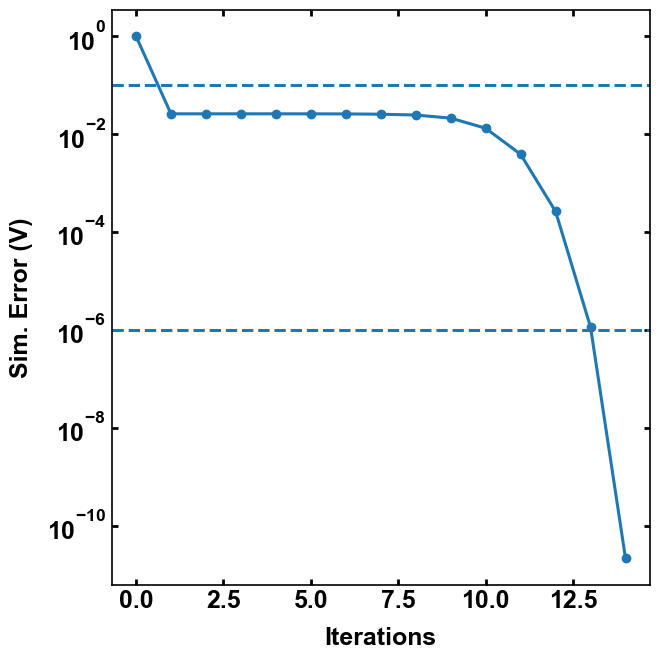

In [7]:

simulator = DeviceSimulator(device_params)
simulator.solve_device_state()

## Visualizing

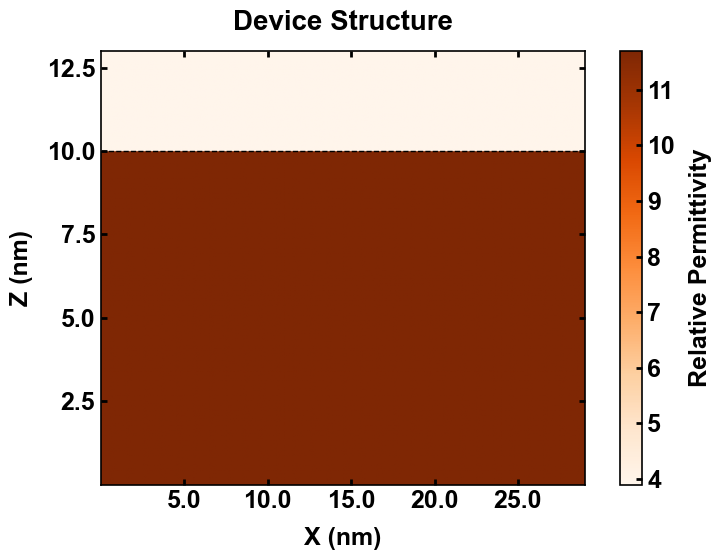

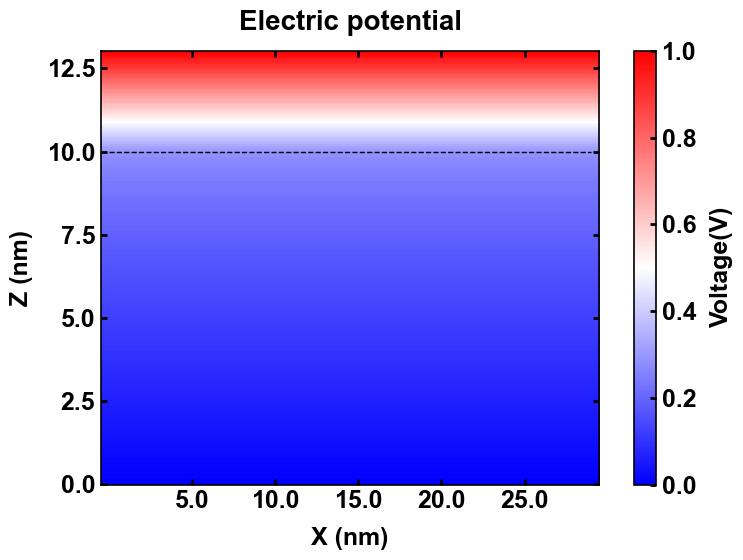

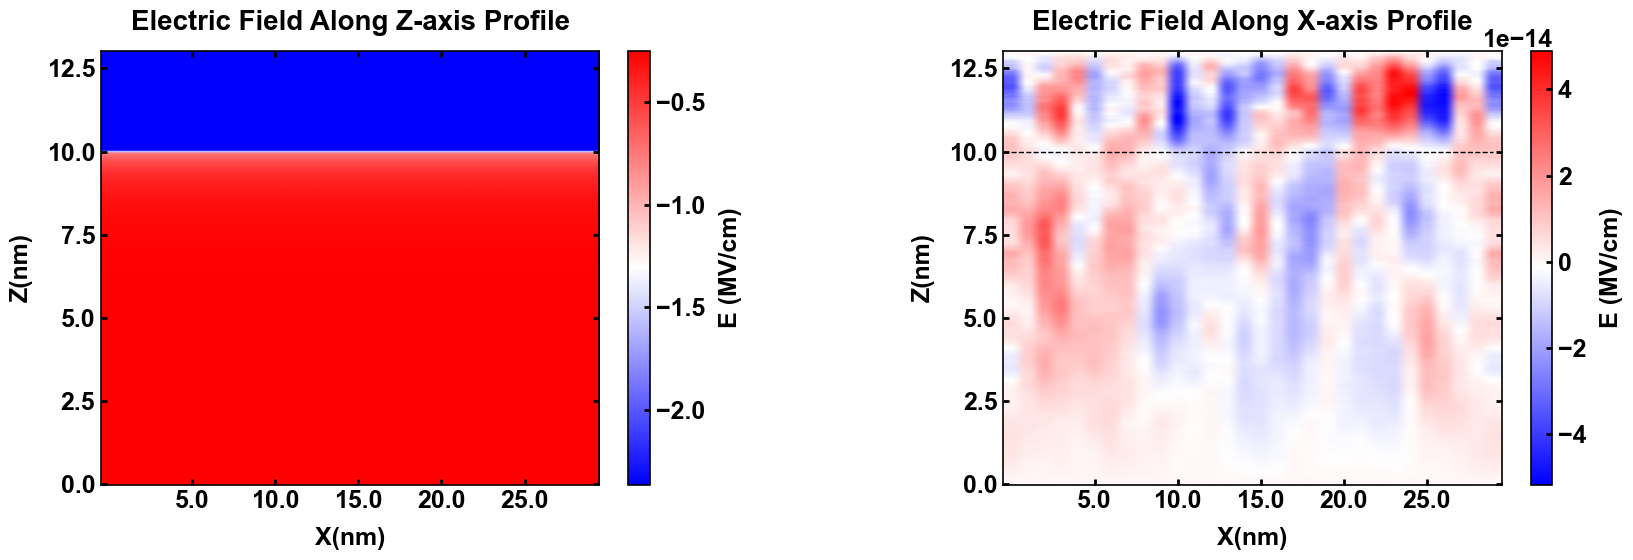

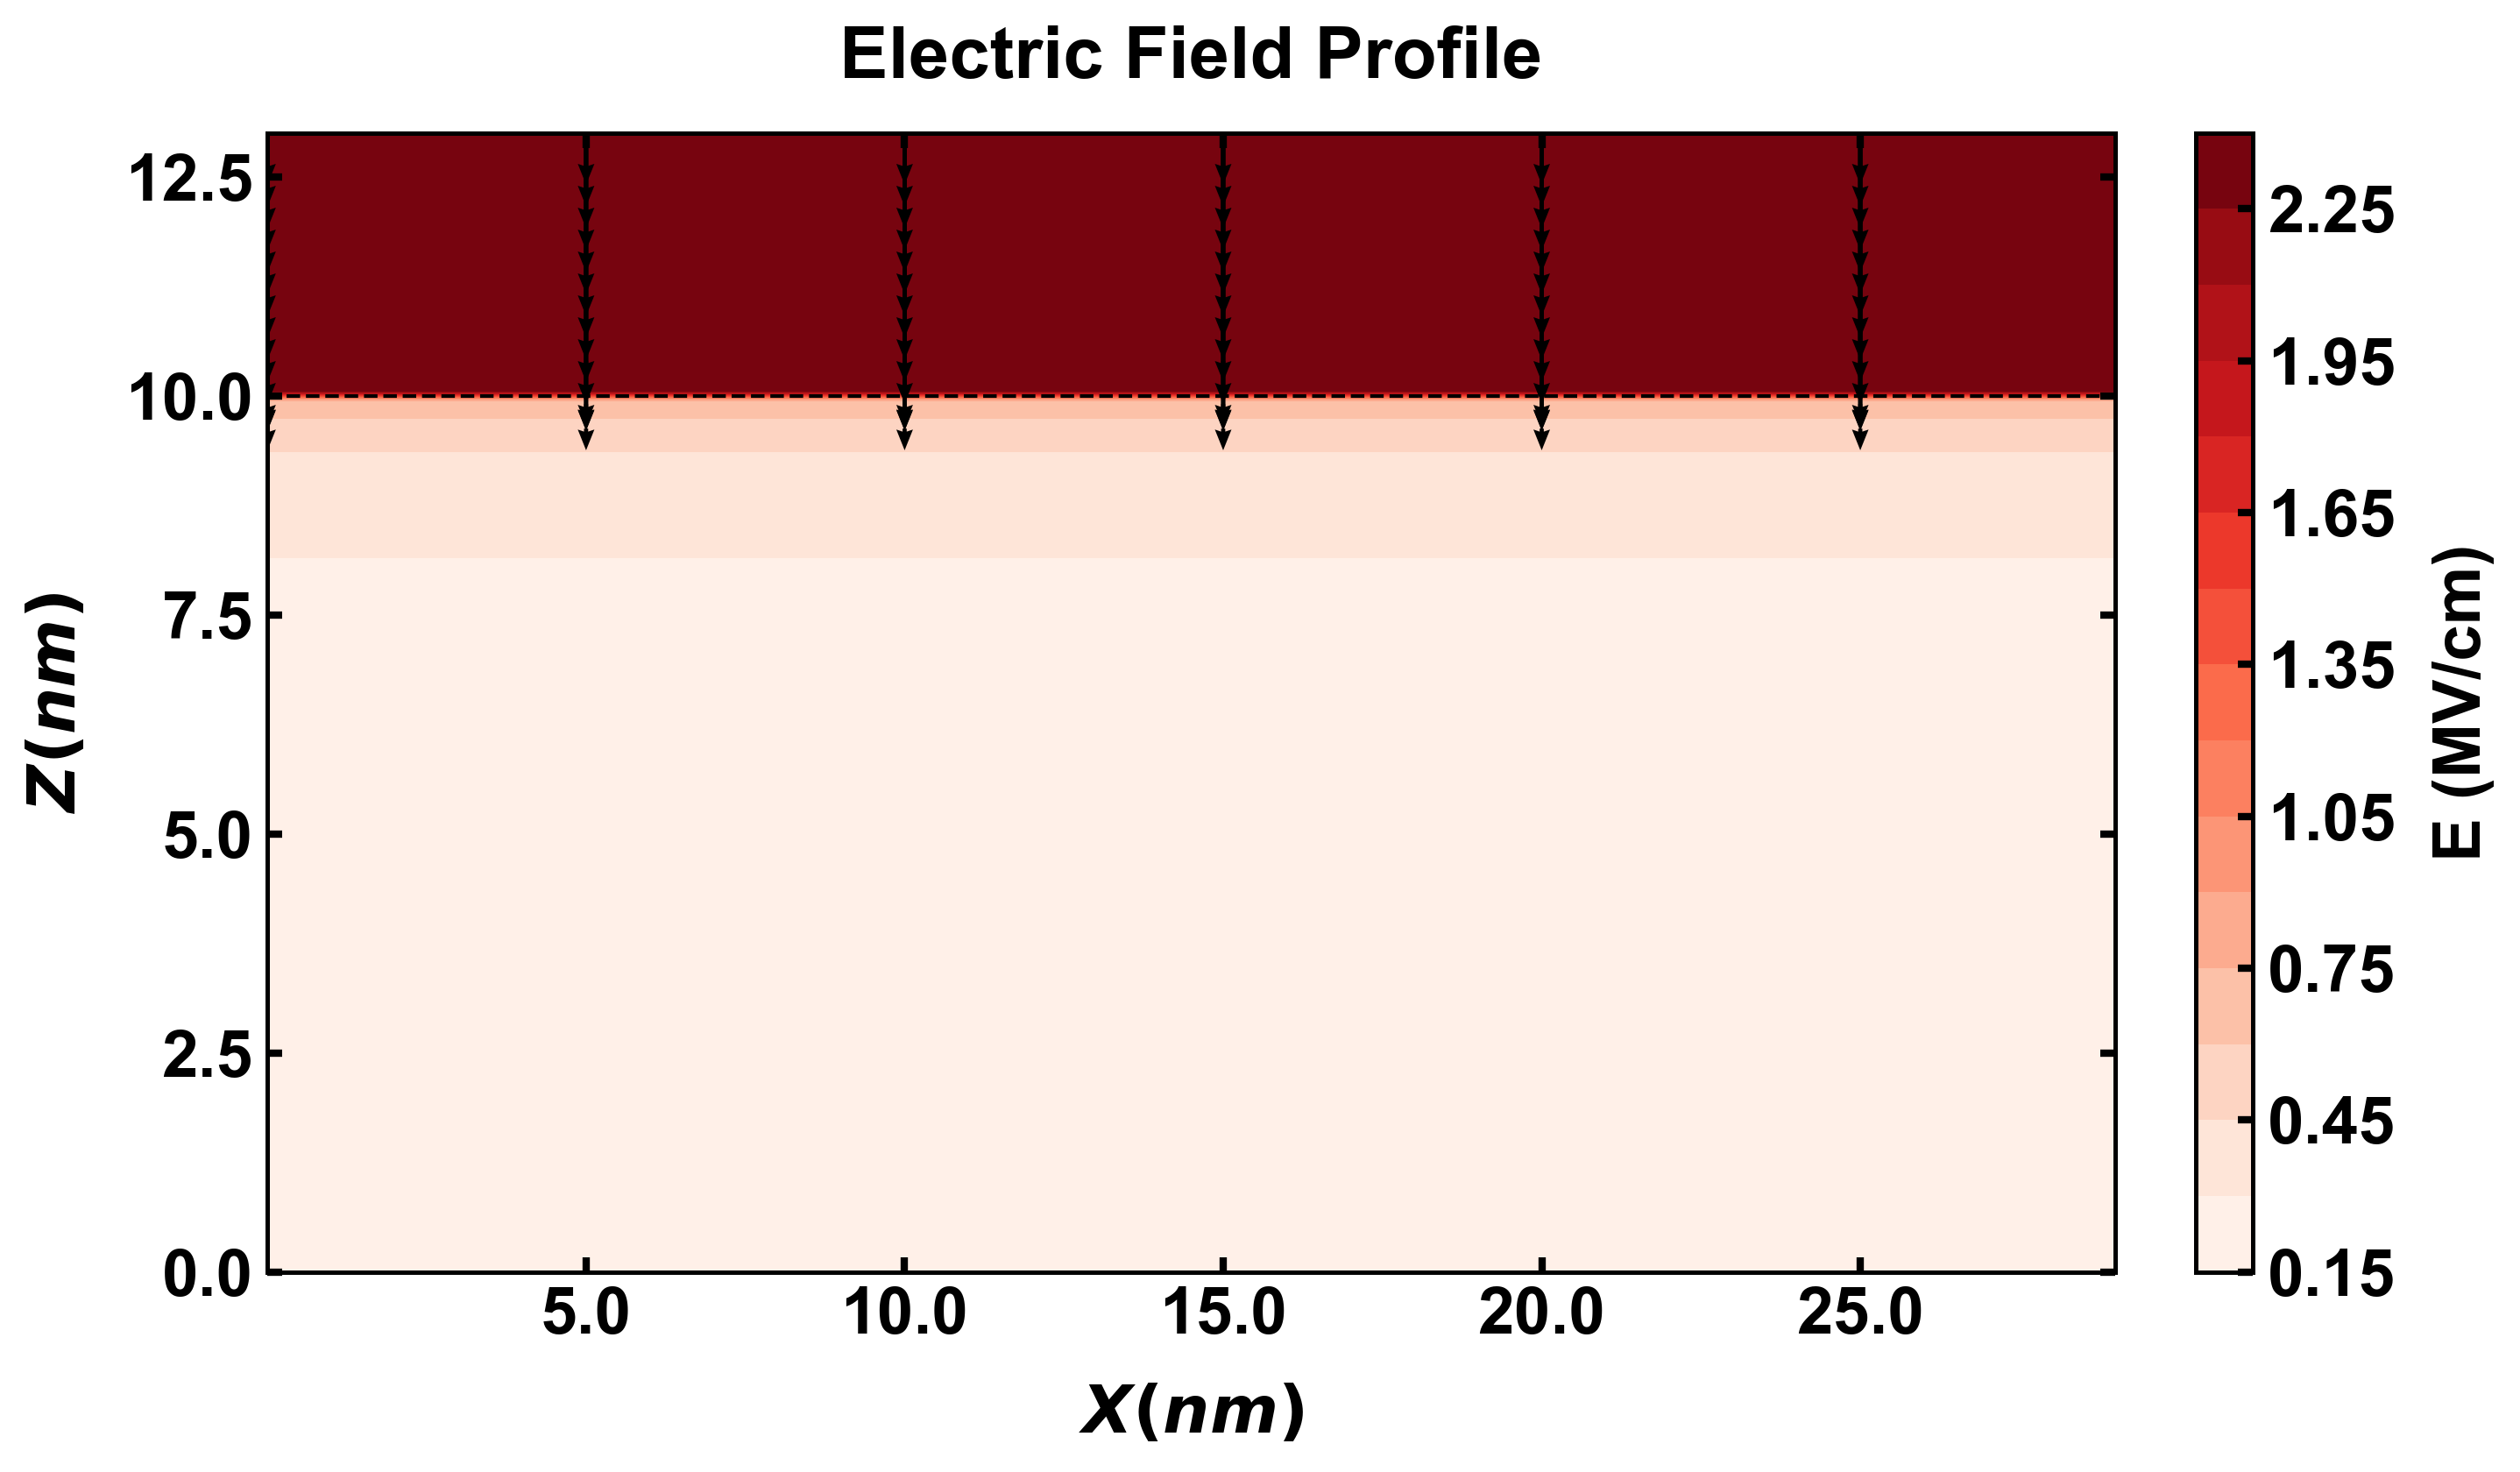

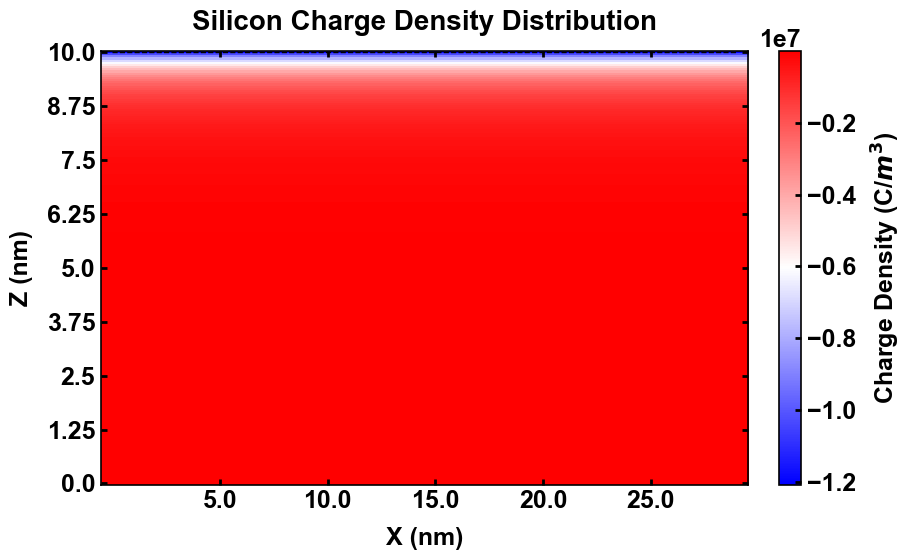

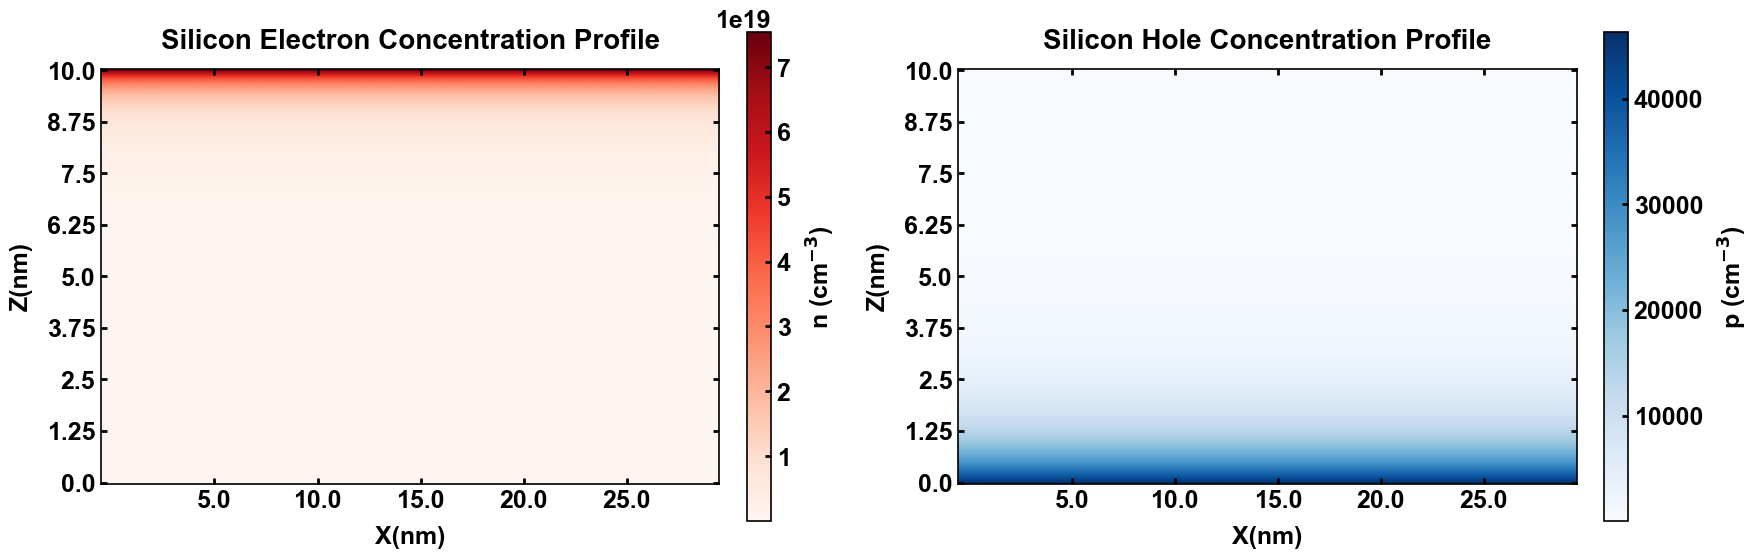

In [8]:
visualizer = DeviceVisualizer(device_params, aspect_ratio=0.1)
visualizer.visualize_permittivity( cmap='Oranges')
visualizer.plot_electric_potential(figsize=(10,6))
visualizer.plot_electric_field(vector_map = True)
visualizer.plot_charge_density()
visualizer.plot_carrier_concentration()